ValueError: 'x' and 'y' must have the same size

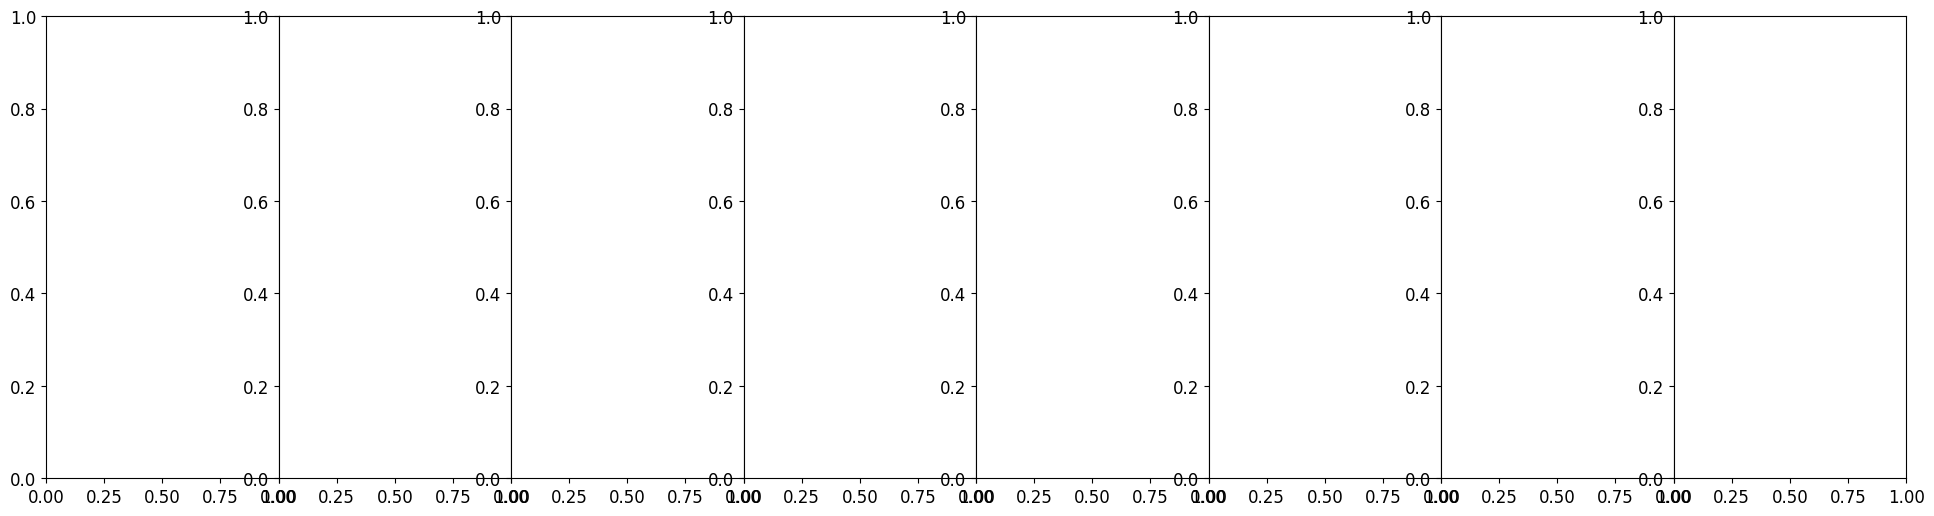

In [3]:
#!/usr/bin/env python
# coding: utf-8

# # Photon ID Run 2 BDT working point optimization

import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import hist
import scipy
from scipy import optimize

datadir = "/home/chardong/y_identification/Venv/save_pkl/df_test_sample_hard_scattering/"
savedir = "/home/chardong/y_identification/Venv/save_plots/"

df = pd.read_pickle(datadir+"df_test_sample_hard_scattering_skim30.pkl")

edges_eta = [0 , 0.6  ,  0.8  ,  1.15  ,  1.37  , 1.52 ,  1.81  ,  2.01  ,  2.37 ]
edges_pt_bkg = [ 20.,  25.,  30.,  35.,  40.,  45., 50., 55., 65., 490. ]

axis_eta = hist.axis.Variable(edges_eta, name="eta", label=r"$\eta$")
axis_pt_bkg = hist.axis.Variable(edges_pt_bkg, name='pt', label=r"$p_T$ [GeV]")
axis_mu = hist.axis.Variable(edges_mu, name='evt_mu', label=r"$evt_\mu$ [GeV]")

# Preselection on photon passing Loose cut-based selection 
df = df.query('y_IsLoose == 1')
df['y_abs_eta'] = np.abs(df['y_eta'])

# Assigning indices corresponding to bins to each event in dataset
df = df.assign(eta_bin=axis_eta.index(df['y_abs_eta']))
df = df.assign(pt_bin_bkg=axis_pt_bkg.index(df['y_pt']))
df = df.assign(mu_bin_sig=axis_mu.index(df['evt_mu']))
df = df.assign(mu_bin_bkg=axis_mu.index(df['evt_mu']))

df_sig = df.query('truth_label==1')
df_bkg = df.query('truth_label==0')

# Compute efficiency and rejection for cut-based Tight identification
df_sig_tight = df_sig[(df_sig["y_IsTight"]==1)]
df_bkg_tight = df_bkg[(df_bkg["y_IsTight"]==1)]

den_sig = hist.Hist(axis_eta, axis_pt_bkg).fill(df_sig["y_abs_eta"], df_sig["y_pt"])
den_bkg = hist.Hist(axis_eta, axis_pt_bkg).fill(df_bkg["y_abs_eta"], df_bkg["y_pt"])

num_sig_tight = hist.Hist(axis_eta, axis_pt_bkg).fill(df_sig_tight["y_abs_eta"], df_sig_tight["y_pt"])
num_bkg_tight = hist.Hist(axis_eta, axis_pt_bkg).fill(df_bkg_tight["y_abs_eta"], df_bkg_tight["y_pt"])

eff_sig_tight = (num_sig_tight/den_sig).values()
efferr_sig_tight = np.sqrt(eff_sig_tight*(1.-eff_sig_tight)/den_sig.values())
eff_bkg_tight = (num_bkg_tight/den_bkg).values()
efferr_bkg_tight = np.sqrt(eff_bkg_tight*(1.-eff_bkg_tight)/den_bkg.values())

# BDT working point optimization
def compute_eff_BDT(df, threshold):
    '''Return efficiency of a given selection on BDT score'''
    return (df['Original_signal_score'] > threshold).sum() / len(df)

def find_cut_with_root_scalar(df, target_efficiency):
    '''Find selection on BDT score corresponding to target efficiency'''
    result = scipy.optimize.root_scalar(
        lambda x: compute_eff_BDT(df, x) - target_efficiency, bracket=(0., 1.0), 
        method='brenth', options={'xtol': 1E-5, 'maxiter': 50}
    )
    return result.root

df_bkg_indexed = df_bkg.set_index(['pt_bin_bkg', 'eta_bin']).sort_index()

# Search for optimal selection on BDT score separately in all eta and pT bins
bdt_cut_same_background_efficiency_tight = {} # store optimal BDT thresholds
for (ieta, ipt), eff_tight in np.ndenumerate(eff_bkg_tight): 
    # select subsample of events corresponding to the current eta and pT bin
    df_bin = df_bkg_indexed.loc[ipt, ieta] # using indexed df to speedup selection
    # find and store optimal BDT selection for current bin
    cut_BDT = find_cut_with_root_scalar(df_bin, target_efficiency=eff_tight)
    bdt_cut_same_background_efficiency_tight[ipt, ieta] = cut_BDT

bdt_cut_same_background_efficiency_tight = pd.Series(bdt_cut_same_background_efficiency_tight).sort_index()
bdt_cut_same_background_efficiency_tight.index.names = ['pt_bin_bkg', 'eta_bin']

df = df.merge(bdt_cut_same_background_efficiency_tight.rename('BDTcut_samebkgeff_tight'), 
             on=['pt_bin_bkg', 'eta_bin'], how="left")
df = df.assign(pass_BDTcut_samebkgeff_tight = df['Original_signal_score'] > df['BDTcut_samebkgeff_tight'])

# Compute efficiency and rejection for BDT working point
df_sig = df.query('truth_label == 1')
df_bkg = df.query('truth_label == 0')

df_sig_bdt = df_sig.query('pass_BDTcut_samebkgeff_tight')
num_sig_bdt = hist.Hist(axis_eta, axis_pt_bkg).fill(df_sig_bdt["y_abs_eta"], df_sig_bdt["y_pt"])

df_bkg_bdt = df_bkg.query('pass_BDTcut_samebkgeff_tight')
num_bkg_bdt = hist.Hist(axis_eta, axis_pt_bkg).fill(df_bkg_bdt["y_abs_eta"], df_bkg_bdt["y_pt"])

eff_sig_bdt = (num_sig_bdt / den_sig).values()
efferr_sig_bdt = np.sqrt(eff_sig_bdt * (1 - eff_sig_bdt) / den_sig.values())
eff_bkg_bdt = (num_bkg_bdt / den_bkg).values()
efferr_bkg_bdt = np.sqrt(eff_bkg_bdt * (1 - eff_bkg_bdt) / den_bkg.values())

# Plot efficiencies
mu = axis_mu.centers

plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(24,6))
fig.subplots_adjust(wspace=.0, hspace=.0)

for i in range(8):
    ax[i].errorbar(mu, eff_sig_tight[:, i], efferr_sig_tight[:, i], fmt=".", label='Signal efficiency Tight', color='blue')
    ax[i].errorbar(mu, eff_sig_bdt[:, i], efferr_sig_bdt[:, i], fmt="o", fillstyle='none', label='Signal efficiency BDT', color='orange')
    if i != 0:
        ax[i].set_yticks([])
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set(title=text)
    ax[i].set_xlim([0, 70])
    ax[i].set_ylim([0, 1.1])
    
ax[0].set_ylabel("Signal efficiency", fontsize=14)
ax[3].set_xlabel("$evt_{\mu}$ [GeV]", fontsize=20)
ax[1].set_zorder(ax[1].get_zorder() + 1)
ax[1].legend(fontsize=12)

#plt.savefig(savedir+"BDT_PID_efficiency_vs_evt_mu.pdf")
plt.show()
